# Hugging Face Segformer model for cell segmentation 

Here we will be testing the Hugging Face segformer model ([docs](https://huggingface.co/docs/transformers/v4.21.1/en/model_doc/segformer)) on the [mini-cell-segmentation](https://github.com/rosikand/easyset/tree/main/mini-cell-segmentation) dataset. 

## 1. Load in the data 

In [44]:
import pickle
in_file = open("data/cell.pkl", 'rb')
dset = pickle.load(in_file)

In [54]:
import torch
import torchvision
from torch.utils.data import Dataset, TensorDataset

class GetDataset(Dataset):
    def __init__(self, data_set): # samples and labels are stored in tuples in data_set (list)
        self.data_distribution = data_set
    
    def __getitem__(self, index):
        sample = self.data_distribution[index][0]
        label = self.data_distribution[index][1]
        return (torch.tensor(sample, dtype=torch.float), torch.tensor(label, dtype=torch.float))
    
    def __len__(self):
        return len(self.data_distribution)

In [55]:
torch_set = GetDataset(dset)
trainloader = torch.utils.data.DataLoader(torch_set, batch_size=1)

The data consists on two labels: cell or background. Let's visualize a sample. 

Image shape:  torch.Size([1, 3, 128, 128])
Mask shape:  torch.Size([1, 2, 128, 128])


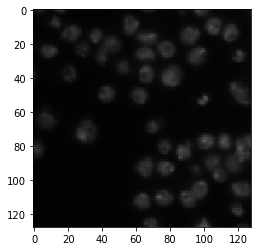

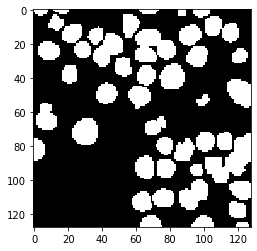

In [56]:
from rsbox import ml
for sample in trainloader:
    print("Image shape: ", sample[0].shape)
    print("Mask shape: ", sample[1].shape)
    ml.plot(sample[0])
    ml.plot(sample[1][0][1], color=False)
    break

## 2. Model 

The HF Segformer model requires some preprocessing to be done to the inputs before inputting it into the raw model (because of the architecture layout). Luckily, HF provides us with a function to handle this for us. Basically equivalent to `preprocessing_fn` from PyTorch smp.  

In [87]:
import numpy as np

In [88]:
from transformers import SegformerFeatureExtractor
feature_extractor = SegformerFeatureExtractor(do_resize=False, do_normalize=False)

In [89]:
feature_extractor

SegformerFeatureExtractor {
  "do_normalize": false,
  "do_resize": false,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 512
}

/tmp/ipykernel_19794/1251756811.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample[0])


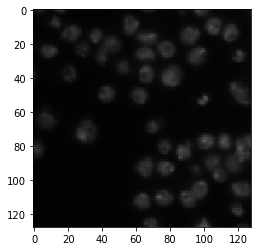

In [96]:
sample = feature_extractor(torch_set[0][0])['pixel_values']
sample = torch.tensor(sample[0])
sample.size()
ml.plot(sample)

**Build the model!**: 
- Requires a SegformerConfig to be passed in. See docs for the params. 
- model = straight from the api! 

In [104]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig
configuration = SegformerConfig(num_labels=2)
model = SegformerForSemanticSegmentation(configuration)

In [105]:
type(model)

transformers.models.segformer.modeling_segformer.SegformerForSemanticSegmentation

In [106]:
out = model(torch.unsqueeze(sample, dim=0))

In [107]:
out.logits.shape

torch.Size([1, 2, 32, 32])

WHAT?! Why is our logit output downscaled?! The docs explains why (for a reason I don't quite get). But as [this](https://huggingface.co/blog/fine-tune-segformer) blog post states, because our model outputs logits with dimensions height/4 and width/4, we have to upscale them. 

In [113]:
import torch
from torch import nn

logits_tensor = nn.functional.interpolate(
        out.logits,
        size=(128, 128),
        mode="bilinear",
        align_corners=False,
    )

logits_tensor.shape

torch.Size([1, 2, 128, 128])

In [117]:
argmaxd = logits_tensor.argmax(dim=1)

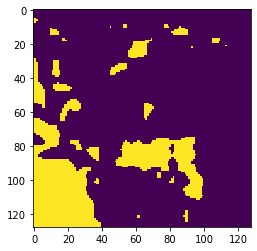

In [120]:
ml.plot(argmaxd)

Nice... let us get to training! 

## 3. Training 

In [122]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [123]:
model.to(device)
print("buffer")

buffer


In [124]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [125]:
import segmentation_models_pytorch as smp
loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

In [134]:
def interpolate_logits(logits, new_size):
    logits_tensor = nn.functional.interpolate(
        logits,
        size=(128, 128),
        mode="bilinear",
        align_corners=False,
    )
    return logits_tensor

In [135]:
%%time
# training loop 
import time

enum = 0
elosses = []
NUM_EPOCHS = 50
start_time = time.time()
epoch_time = time.time()

for epoch in range(NUM_EPOCHS):
    enum += 1
    running_loss = 0.0
    
    for data in trainloader:
        # 1. get data 
        inputs = data[0].to(device)
        masks = data[1].to(device)
        
        # 2. zero out grads 
        optimizer.zero_grad()
        
        # 3. forward + backward + optimize
        logits = model(inputs).logits
        logits = interpolate_logits(logits, (128, 128))
        loss_val = loss(logits, masks)
        loss_val.backward()
        optimizer.step()
        
        running_loss += loss_val
    
    # loss stats 
    epoch_loss = (running_loss/len(trainloader)).cpu().detach().numpy()
    elosses.append(epoch_loss)
    print('Loss epoch {}: '.format(enum), epoch_loss)
    
    # timing 
    new_time = time.time()
    print("Total time (s): ", int(new_time - start_time))
    print("Epoch time (s): ", int(new_time - epoch_time))
    print("-------------------------")
    epoch_time = time.time()

Loss epoch 1:  0.45684505
Total time (s):  0
Epoch time (s):  0
-------------------------
Loss epoch 2:  0.3987007
Total time (s):  1
Epoch time (s):  0
-------------------------
Loss epoch 3:  0.3486563
Total time (s):  1
Epoch time (s):  0
-------------------------
Loss epoch 4:  0.314188
Total time (s):  2
Epoch time (s):  0
-------------------------
Loss epoch 5:  0.2905194
Total time (s):  2
Epoch time (s):  0
-------------------------
Loss epoch 6:  0.27278724
Total time (s):  3
Epoch time (s):  0
-------------------------
Loss epoch 7:  0.25859186
Total time (s):  3
Epoch time (s):  0
-------------------------
Loss epoch 8:  0.24698952
Total time (s):  4
Epoch time (s):  0
-------------------------
Loss epoch 9:  0.23717739
Total time (s):  4
Epoch time (s):  0
-------------------------
Loss epoch 10:  0.22881941
Total time (s):  5
Epoch time (s):  0
-------------------------
Loss epoch 11:  0.2218224
Total time (s):  5
Epoch time (s):  0
-------------------------
Loss epoch 12:

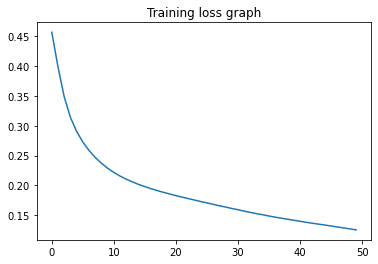

In [136]:
import matplotlib.pyplot as plt
plt.plot(elosses)
plt.title("Training loss graph")
plt.show()

## 4. Test 

We will also use the [`mean_iou`](https://huggingface.co/spaces/evaluate-metric/mean_iou) metric from Hugging Face metrics. 

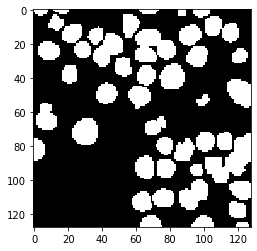

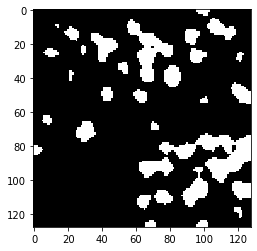

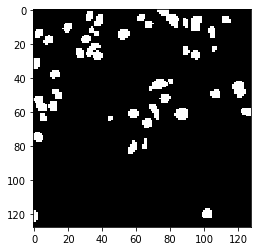

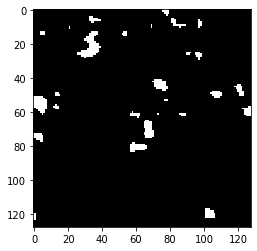

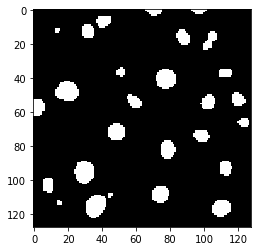

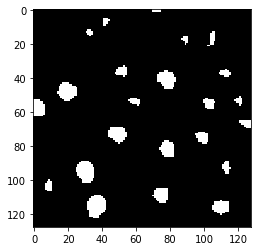

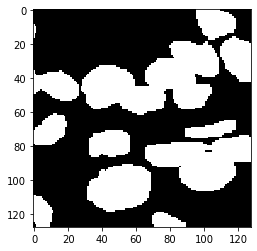

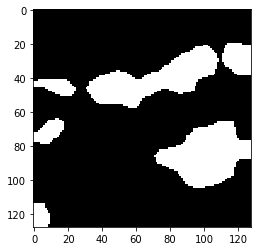

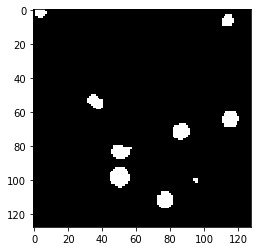

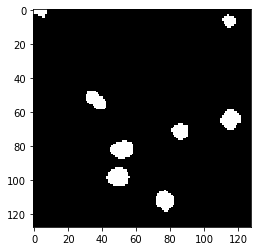

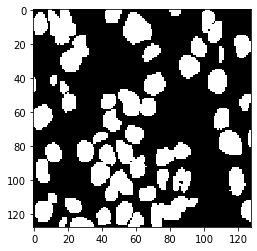

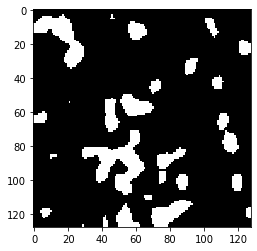

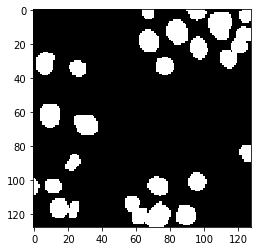

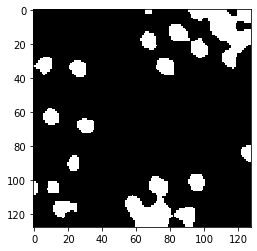

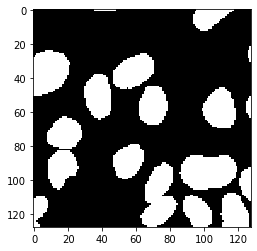

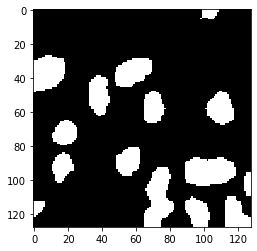

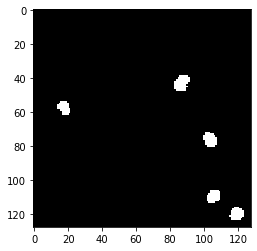

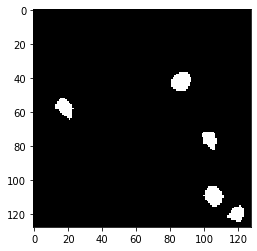

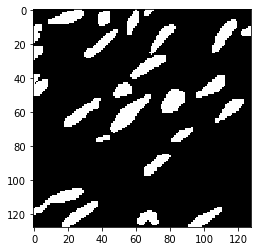

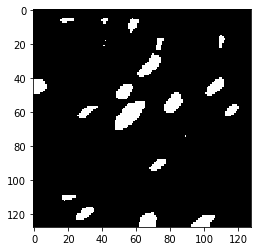

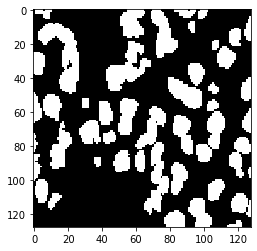

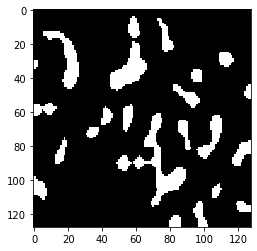

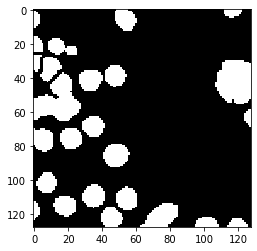

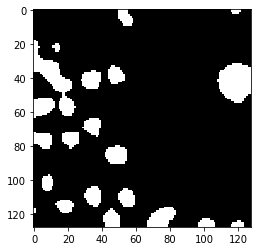

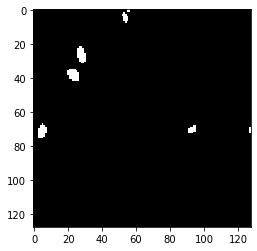

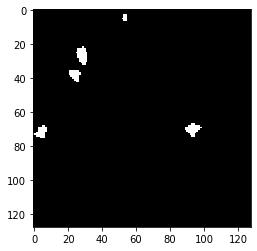

In [156]:
for img, mask in trainloader:
    img = img.to(device)
    logits = model(img).logits
    pred_map = interpolate_logits(logits, (128, 128)).argmax(dim=1)
    ml.plot(mask[0][1], False)
    ml.plot(pred_map.cpu(), False)

Nice! It works! 